## Beginners guide to Geospatial analysis 
by Gala Camacho 

In [1]:
import requests, zipfile, io
import geopandas as gpd

%matplotlib inline

Read a file from a url

we grab it from here https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202018?OpenDocument

In [2]:
zip_url = "https://www.abs.gov.au/ausstats/Subscriber.nsf/log?openagent&1270055003_lga_2018_aust_shape.zip&1270.0.55.003&Data%20Cubes&FCDD3670BE71AA90CA258339000D8477&0&July%202018&05.11.2018&Previous"

r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(".")

In [3]:
lgas = gpd.read_file("LGA_2018_AUST.shp")

In [4]:
lgas.sample(5)

LGA_CODE18          LGA_NAME18 STE_CODE16         STE_NAME16  AREASQKM18  \
319      43360  Kingston (DC) (SA)          4    South Australia   3339.7952   
81       15750        Narrabri (A)          1    New South Wales  13014.9937   
337      45680        Playford (C)          4    South Australia    345.2030   
87       16100          Oberon (A)          1    New South Wales   3625.0470   
390      51750       Claremont (T)          5  Western Australia      4.9556   

                                              geometry  
319  POLYGON ((139.84737 -36.83072, 139.84878 -36.8...  
81   POLYGON ((148.93192 -30.29956, 148.93158 -30.2...  
337  POLYGON ((138.68749 -34.75464, 138.68693 -34.7...  
87   POLYGON ((149.61555 -33.70256, 149.61555 -33.7...  
390  POLYGON ((115.77169 -31.97388, 115.77169 -31.9...

In [5]:
# clean up ghost lgas
lgas = lgas.loc[~lgas['geometry'].isna()]

In [6]:
# see individual shape
lgas.loc[0]['geometry']

You can have a simple look at your data using matplotlib

In [7]:
lgas.plot()

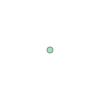

In [8]:
# find the centroid of your polygons
lgas_centroid = lgas.centroid

# find the centroid of your polygons
lgas_centroid[0]

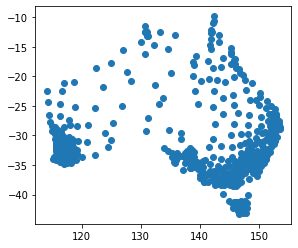

In [9]:
lgas_centroid.plot()

Knowing the CRS of your geospatial file is important. 
Mostly when mixing files, you want to make sure that all your files are always in the same crs

In [10]:
lgas.crs
# https://epsg.io/4283

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The crs it is in, has units of degrees, 

we might want one that has units of meteres and that is targetted for Australia, 

so let change our crs. 
https://epsg.io/28355

In [11]:
lgas_flat = lgas.to_crs(epsg=28355)

#notice how your map changes!
lgas_flat.plot()

Imagine I am interested in knowing what is around some place.

If only addresses are provided, you can geocode the addresses.

You can then create "search polygons" based on the centre point and a radius.


In [12]:
points_of_interest = [{'location':'Our Community House',
                       'radius_of_interest':5000,
                       'address':'552 Victoria St, North Melbourne VIC 3051'},
                      {'location':'Marise Payne',
                       'radius_of_interest':7000,
                       'address':'2/12 Macquarie St, Parramatta NSW 2150'}]

In [13]:
# You can do this directly with GeoPandas (but it tends to time out)

# pois = gpd.GeoDataFrame(points_of_interest)
# pois['geometry'] = gpd.tools.geocode(pois['address'])

In [14]:
# OR you can do this independently with geopy and OSM Nominatim (tends to work much better)

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Data for Good Datathon", timeout=5)

from shapely.geometry import Point

for poi in points_of_interest:
    location = geolocator.geocode(poi['address'])
    poi['latitude'] = location.latitude
    poi['longitude'] = location.longitude
    # make it into a point gpd will be able to understand Point(x,y) ie Point(longitude,latitude)
    poi['geometry'] = Point(poi['longitude'],poi['latitude'])

# if you construct a geodataframe already with a geometry, it will find it. 
pois = gpd.GeoDataFrame(points_of_interest)

In [15]:
# don't forget the crs
# you have made your data from lat lons so 
pois.crs = {'init':'epsg:4283'}
pois.plot()

/anaconda3/envs/dfsg2020/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
# to create your polygons around the point
# remember, you want to use meteres, so you must change crs
pois_flat = pois.to_crs(epsg=28355)
pois_flat['area_of_interest'] = pois_flat.buffer(pois['radius_of_interest'])
pois_flat

location  radius_of_interest  \
0  Our Community House                5000   
1         Marise Payne                7000   

                                     address   latitude   longitude  \
0  552 Victoria St, North Melbourne VIC 3051 -37.805728  144.955090   
1     2/12 Macquarie St, Parramatta NSW 2150 -33.815902  151.006691   

                         geometry  \
0  POINT (319980.208 5813769.787)   
1  POINT (870921.397 6251031.341)   

                                    area_of_interest  
0  POLYGON ((324980.208 5813769.787, 324956.131 5...  
1  POLYGON ((877921.397 6251031.341, 877887.690 6...

In [17]:
pois_flat.loc[0]['area_of_interest']

In [18]:
# if you wanted to make area_of_interest plottable with matplotlib 
# you need to make it into a string of 'well known text' ie wkt
# sadly once you do that it will no longer be a point object, which is annoying

# pois_flat['area_of_interest'] = pois_flat['area_of_interest'].apply(lambda x: x.wkt).values
# pois_flat.plot(column='area_of_interest')

In [19]:
aois_flat = gpd.GeoDataFrame(pois_flat[['area_of_interest']],geometry='area_of_interest')
aois_flat.crs = {'init':'epsg:28355'}

/anaconda3/envs/dfsg2020/lib/python3.8/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [20]:
aois = aois_flat.to_crs(epsg=4283)

Find all LGA centroids in an area of interest

Then find all LGAS that intersect with the area of interest

In [21]:
aoi = aois.loc[0]

lgas_centroid.loc[lgas_centroid.within(aoi['area_of_interest'])].plot()

In [22]:
lgas.loc[lgas.intersects(aoi['area_of_interest'])].plot()

In [23]:
# if you want to see both in the map
base = lgas.loc[lgas.intersects(aoi['area_of_interest'])].plot(color='blue', edgecolor='black')
aois.head(1).plot(ax=base,alpha=0.5, edgecolor='white')

# note that we refer back to aois in order to use matplotlib plotting

maybe you now want to measure the distance from you poi to the centroids

In [24]:
centroids_within_aoi = lgas_centroid.loc[lgas_centroid.within(aoi['area_of_interest'])]

centroids_within_aoi_flat = centroids_within_aoi.to_crs(epsg=28355)
poi_flat = pois_flat.loc[0]

centroids_within_aoi_flat['distance_to_poi'] = centroids_within_aoi_flat.distance(poi_flat['geometry'])
# 

In [25]:
centroids_within_aoi_flat['distance_to_poi']

174    1118.258712
207    3846.227396
dtype: float64

you can also do this directly using geopy and the lat,lon's

https://pypi.org/project/geopy/


if you want to get more fancy with your visualisations you can look into 

Mapbox (for nice interactive basemaps)

Plotly

Carto

Bokeh

In [26]:
# for an interactive map, try plotly below
# but be careful with plotting too many polygons at once, it takes a lot of memory and power!

import plotly.express as px
from plotly.offline import plot 
# 
temp = lgas.loc[lgas.intersects(aoi['area_of_interest'])]
poi = pois.loc[0]

fig = px.choropleth_mapbox(temp[["LGA_CODE18"]], geojson=temp.__geo_interface__,
                           locations="LGA_CODE18",
                           featureidkey="properties.LGA_CODE18",
                           color="LGA_CODE18",
                           mapbox_style="carto-positron",
                           zoom=9,
                           center={'lat':poi['latitude'], 'lon':poi['longitude']}
                          )


plot(fig)

'temp-plot.html'